# d2l.ai - Notes for 2.5. Automatic Differentiation

Deep learning frameworks provide automatic differentiation (autograd): build a computational graph (how each values depend on others) and to calculate derivatives, automatic differentiation works backwards through this graph applying the chain rule (backpropagation). 

In [3]:
import torch

## A Simple Function

Differentiating the function $y = 2\mathbf{x}^{\top}\mathbf{x}$ with respect to the column vector $\mathbf{x}$.

We avoid allocating new memory every time we take a derivative  because deep learning requires successively computing derivatives with respect to the same parameters a great many times, and we might risk running out of memory. 

Note that the gradient of a scalar-valued function with respect to a vector $\mathbf{x}$ is vector-valued with the same shape as $\mathbf{x}$.

In [7]:
x = torch.arange(4.0)
x.requires_grad_(True)
# or x = torch.arange(4.0, requires_grad=True)
x.grad

In [8]:
# y = 2x^T.x
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

- Take the gradient of `y`with respect to `x` by calling its `backward` method. 
- Access the gradient via `x`'s `grad` attribute.

In [9]:
y.backward()

In [10]:
x.grad

tensor([ 0.,  4.,  8., 12.])

In [8]:
x.grad == 4 * x

tensor([True, True, True, True])

- PyTorch does not automatically reset the gradient buffer. 
- Instead, the new gradient is added to the already-stored gradient. This behavior comes in handy when we want to optimize the sum of multiple objective functions. 
- Call `x.grad.zero_()` to reset gradient buffer

In [13]:
x.grad.zero_()

tensor([0., 0., 0., 0.])

In [14]:
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

Note: 
`y = x.sum()` means $y = \displaystyle \sum_{i=1}^n x_i$. Then $\nabla_x y = \bigg[\partial_{x_1} \displaystyle \sum_{i=1}^n x_i \ \partial_{x_2} \displaystyle \sum_{i=1}^n x_i \ ... \ \partial_{x_n} \displaystyle \sum_{i=1}^n x_i\bigg]^\top = [1 \ 1 \ ... 1]^\top$

## Backward for Non-Scalar Variables

- Jacobian matrix containing partial derivatives of each component of `y` with each component of `x`
- In deep learning, invoking `backward` on a non-scalar tensor in PyTorch requires specifying how to reduce the object to a scalar.
- Need to provide a vector $\mathbf{v}$ (Call gradient) to compute $\mathbf{v}^\top \partial_{\mathbf{x}} \mathbf{y}$ instead of $\partial_{\mathbf{x}} \mathbf{y}$ during backward

In [15]:
%%time
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

CPU times: total: 15.6 ms
Wall time: 170 ms


tensor([0., 2., 4., 6.])

(In this situation, $\mathbf{v}$ is `torch.ones(len(y))`, and $\mathbf{v}^\top . \mathbf{y} = \sum y_i$)

In [16]:
%%time
x.grad.zero_()
y = x * x
y.sum().backward()
x.grad

CPU times: total: 15.6 ms
Wall time: 12.2 ms


tensor([0., 2., 4., 6.])

## Detaching Computation

- Sometimes we need to move certain calculations outside of the computational graph.
- Use case: 
    - Suppose we have $z = x . y$ and $y = x^2$ and we just want to focus on the direct influence of $x$ on $z$. 
    - By detaching $y$, we create a new variable $u$ with the same value as $y$ but has no ancestors in the graph. Then if we take gradient of $z = x.u$ with respect to $x$, the result will be $u$ (not $3x^2$)
    - The computational graph leading to $y$ persists and thus we can calculate the gradient of $y$ with respect to $x$.

In [9]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Gradients and Python Control Flow

One benefit of using automatic differentiation is that even if building the computational graph of **a function required passing through a maze of Python control flow** (e.g., conditionals, loops, and arbitrary function calls), **we can still calculate the gradient of the resulting variable.** 

In [9]:
# To illustrate this, consider the following code snippet where the number of iterations of the `while` loop and the evaluation of the `if` statement both depend on the value of the input `a`.
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [14]:
# input a random variable
a = torch.randn(size=(), requires_grad=True)
print(a)
d = f(a)
print(d)
d.backward()

tensor(-0.9464, requires_grad=True)
tensor(-193827.7188, grad_fn=<MulBackward0>)


Even though our function `f` is, for demonstration purposes, a bit contrived,
its dependence on the input is quite simple: 
it is a *linear* function of `a` 
with piecewise defined scale. 
As such, `f(a) / a` is a vector of constant entries 
and, moreover, `f(a) / a` needs to match 
the gradient of `f(a)` with respect to `a`.


In [15]:
a.grad == d / a

tensor(True)

Dynamic control flow is very common in deep learning. For instance, when processing text, the computational graph depends on the length of the input. In these cases, automatic differentiation becomes vital for statistical modeling since it is impossible to compute the gradient *a priori*. 

## Discussion

You have now gotten a taste of the power of automatic differentiation. The development of libraries for calculating derivatives both automatically and efficiently has been a massive productivity booster for deep learning practitioners, liberating them so they can focus on less menial. Moreover, autograd lets us design massive models for which pen and paper gradient computations would be prohibitively time consuming. Interestingly, while we use autograd to *optimize* models (in a statistical sense) the *optimization* of autograd libraries themselves (in a computational sense) is a rich subject of vital interest to framework designers. Here, tools from compilers and graph manipulation are leveraged to compute results  in the most expedient and memory-efficient manner. 

For now, try to remember these basics: 

(i) attach gradients to those variables with respect to which we desire derivatives; 

(ii) record the computation of the target value; 

(iii) execute the backpropagation function; 

(iv) access the resulting gradient.

## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result. 
1. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$. 
1. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously. 
1. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as *backward differentiation*. 
1. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.

### EX1

- Computational complexity: Second derivative requires additional passes through the computational graph
- Memory requirements: Second derivative calculations require storing additional intermediate results and potentially larger structures like the Hessian matrix

### EX2

In [35]:
import torch
x = torch.arange(4.0)
x.requires_grad_(True)
y = torch.dot(x, x)

In [36]:
y.backward()

In [37]:
# Second run
y.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

**Explaination**:
- The .backward() call will automatically free 3 all the intermediate tensors in a computational graph after the backprop.
- In that sense, “double backward” can not be realized unless we specifie 'retain_graph=True'

In [38]:
# fix 
import torch

x = torch.arange(4.0, requires_grad =True)
y = torch.dot(x, x)
y.backward(retain_graph=True)
y.backward()

### EX3

In [42]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [43]:
a = torch.randn(size=(3, 2), requires_grad=True)
d = f(a)
d.sum().backward()

In [44]:
a.grad == d / a

tensor([[True, True],
        [True, True],
        [True, True]])

### EX4

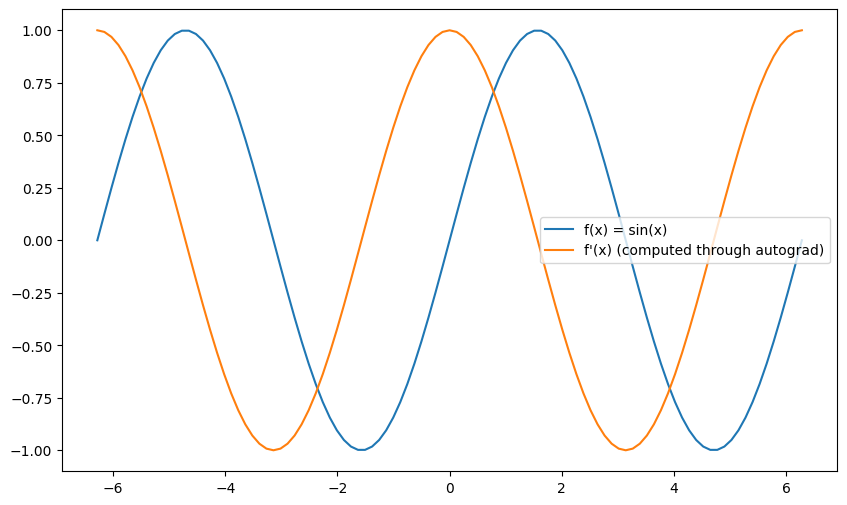

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch

x = torch.linspace(-2*np.pi, 2*np.pi, 101, requires_grad=True)
f = torch.sin(x)
f.sum().backward()
grad = x.grad

plt.figure(figsize=(10,6))
plt.plot(x.detach().numpy(), f.detach().numpy(), label = "f(x) = sin(x)")
plt.plot(x.detach().numpy(), grad.detach().numpy(), label = "f'(x) (computed through autograd)")
plt.legend()
plt.show()

### EX5,6

<img width=600 src = './2.5.jpg'>

### EX7
Skip

### EX8

| Criteria | Forward differentiation | Backward differentiation |
|:--------:|:--------:|:--------:|
| Amount of intermediate data needed | Require storing intermediate values for each variable only once, which keeps memory usage relatively low | Require storing the intermediate values for every variable to compute gradients for all inputs (its parent node variable), which needs more memory.|
| Ability to parallelize steps | Process each input sequentially, which can be harder to parallelize efficiently if you have a large number of input variables | Excellent ability to parallelize because gradients for many parameters can be computed simultaneously, leveraging the full power of parallel hardware like GPUs |
| Size of matrices and vectors | Suitable for low-dimensional inputs and higher-dimensional outputs | Suitable for high-dimensional inputs and lower-dimensional (especially scalar) outputs |

- Parallelize step: can be executed simultaneously rather than sequentially